#### Exercise 4 - DDPG
In this exercise we will train our own agent using [Deep Deterministic Policy Gradient](https://arxiv.org/pdf/1509.02971.pdf) to safely land a lunarlander from [Gymnasium environments](https://gymnasium.farama.org/environments/box2d/lunar_lander/). Previously we looked at the DQN algorithm which works for discrete action spaces. Many real world scenarious, such as robotics or self-driving cars, require the agent/controller to perform on a continuous action space. So it is time to move from discrete world to a continuous world! 


<img src="resources/lunar_lander.gif" alt="Gymnasium" width="20%"/>

<!--  -->
_Agent using random actions to land the lunarlander_

## 0 Setup
These are the same packages as in the last exercise:

In [35]:
!pip install torch
!pip install gymnasium
!pip install swig
!pip install "gymnasium[box2d]"
!pip install matplotlib
!pip install imageio
!pip install minatar

In [3]:
# Imports
from typing import Iterable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

## 1 DDPG
Remember that for Q-learning, we have the following update:

$Q(s,a) \leftarrow Q(s,a) + \alpha (r + \gamma \max_{a'}Q(s', a') - Q(s, a))$

with discount factor $\gamma$, learning rate $\alpha$, reward $r$, sampled state $s$, sampled next state $s'$ and sampled action $a$. The $\max$ operator enumerates through the finite number of discrete actions and chooses the action corresponding to the maximum $Q(s', a')$. The $\max$ operator essentially represents the greedy policy for a discrete case. 

In continuous action settings there are infinite many actions and hence we need a new strategy for selecting actions. This is where the Actor network, $\mu(s)$ comes into play. The actor is the explicit representation of the action selection strategy (or policy). It takes in a state $s$ as input and outputs an action $a$ which it believes will yield the highest $Q$ value in state $s$. (Do you see the resembelance to the $\max$ operator in DQN?)

So we can rewrite the Q-learning update with the actor:

$Q(s,a) \leftarrow Q(s,a) + \alpha (r + \gamma Q(s', \mu(s')) - Q(s, a))$


The critic can then be updated with the Mean Square Loss as before:

$ L(\theta^{Q}) = \mathop{\mathbb{E}}_{(s, a, r, s')\sim D}([r + \gamma Q(s', \mu(s';\theta^{\mu}); \theta^{Q}) - Q(s, a; \theta^{Q})]^2 )$  

where D is a dataset of sampled transitions and $\theta^{Q}$ and $\theta^{\mu}$ are parameters of the critic and actor networks respectively.

The Actor network's objective is to output actions that maximise the value of the Critic. Hence the loss function for the Actor is the negative of its objective which is the value of the Critic.

$L(\theta^{\mu}) =  -\mathop{\mathbb{E}}_{(s)\sim D}(Q(s, \mu(s;\theta^{\mu}); \theta^{Q}))$

---
<span style="color:orange">**EXERCISE**</span>: **DDPG Warm-up**
1. Can you suggest a way to use DQN even in continuous action settings?
2. What could be a potential short coming of your suggested approach above?
3. In DQN, the Q network would only take the observation as input and output Q values for each of the actions, What should the input and outputs be for the Q network (Critic) in continuous settings?
4. Actor's update uses the chain rule for derivatives, complete the following $\frac{\partial Q(s,a)}{\partial \theta^{\mu}} =...$  _(Hint: DDPG paper Eq. 6)_

**Your answers:**
1. According to the DDPG paper, we can simply discretize the action space to adapt DQN in continious action settings. For example, we have a robot with 6 degrees of freedom, meaning it can move in 6 different ways: up and down, left and right, forward and backward. 
2. The number of possible actions will increase exponentially when the number of degrees of freedom will grow. 
3. **Input**: observation and action. **Output**: Q value.
4. $\frac{\partial Q(s,a)}{\partial \theta^{\mu}} = \mathop{\mathbb{E}}_{s_t\sim D}(Q(s, \mu(s;\theta^{\mu}); \theta^{Q}))$
5. $ ∇_θ^μ J ≈ E_{s_t ∼ D} [∇_a Q(s, a | θ^Q) |{s = s_t, a = μ(s_t)} ∇_θ^μ μ(s | θ^μ) |{s = s_t}] $

## 1.1 Critic
We are representing the critic with a deep neural network. 

---
<span style="color:orange">**EXERCISE**</span>: **Implementing the Critic**
In this exercise we are using a state-based (not image based) observations. 
Critic should take in both obsevation and action and output the Q value. 

The architecture consists of Linear layers and ReLu activations:
- fc1: input:(obs_dim + action_dim),  ouput: 256
- fc2: input: 256, output: 256
- fc3: input: 256, output: 1

obs_dim and action_dim can be determined by examining the env using ```env.observation_space.shape``` and ```env.action_space.shape```


Implement this architecture.

In [4]:
class Critic(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int):
        """
        Initialize the Critic network.
        
        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Critic, self).__init__()
        
        self.fc1 = nn.Linear(obs_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, obs: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        self.critic_input = torch.cat([obs, action], dim=1)

        self.critic_input = F.relu(self.fc1(self.critic_input))
        self.critic_input = F.relu(self.fc2(self.critic_input))

        q_value = F.relu(self.fc3(self.critic_input))
        return q_value

## 1.2 Actor 
The actor is also explicitly represented by a neural network. 

---
<span style="color:orange">**EXERCISE**</span>: **Implementing the Actor**
In this exercise we are using a state-based (not image based) observations. 
Actor should take in an observation and output an action.

The architecture consists of Linear layers and ReLU activations:

**NOTE**: The output of the last layer should pass through a tanh (not ReLU) activation and should be scaled and translated according to the environment's action space. Tanh activation restricts the acitons to [-1,1] range and scaling and translation makes sure that the action is within the bounds of the environment's action space.
- fc1: input:(obs_dim),  ouput: 256
- fc2: input: 256, output: 256
- fc3: input: 256, output: action_dim

action_high and action_low can be determined by examining the env using ```env.action_space.high``` and ```env.action_space.low```



Implement this architecture.

In [5]:
class Actor(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, action_low: np.array, action_high: np.array):
        """
        Initialize the Actor network.
        
        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Actor, self).__init__()
        # We are registering scale and bias as buffers so they can be saved and loaded as part of the model.
        # Buffers won't be passed to the optimizer for training!
        self.register_buffer(
            "action_scale", torch.tensor((action_high - action_low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((action_high + action_low) / 2.0, dtype=torch.float32)
        )
        
        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))

        # The output of the last layer is scaled and translated according to the environment's action space.
        # (to make sure that the action is within the bounds of the environment's action space)
        action = x * self.action_scale + self.action_bias
        return action


## Replay Buffer

We can reuse the Replay Buffer from the last exersice!

The replay buffer stores transitions of the form $(s, a, r, s')$ with $s$ as the current state, the action $a$, the reward $r$, and the next state $s'$. The buffer can perform two operations:
- **store**: During sampling we observe transitions and store them with ``buffer.store(...)``. However, the buffer only has a fixed size
(as we cannot store an infinte amount of data). When reaching it, the oldest samples are overwritten first.
- **sample**: For training, we want to sample a batch of transitions from our buffer via ``buffer.sample(...)``. The transitions are sampled uniformly and with replacement i.e. the same transition can be sampled more than once.


In [6]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)   
        self.position = (self.position + 1) % self.max_size         

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """

        obss, acts, rews, next_obss, terms = [], [], [], [], []
        for _ in range(batch_size):
            index = np.random.randint(0, len(self.data))
            
            o, a, r, no, t = self.data[index]
            obss.append(torch.as_tensor(o))
            acts.append(torch.as_tensor(a))
            rews.append(torch.as_tensor(r))
            next_obss.append(torch.as_tensor(no))
            terms.append(torch.as_tensor(t))

        # Stack
        obs_batch = torch.stack(obss)
        action_batch = torch.stack(acts)
        reward_batch = torch.tensor(rews)
        next_obs_batch = torch.stack(next_obss)
        terminated_batch = torch.tensor(terms)

        return obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch

## 1.3 Algorithm
In this section, we will first look at the update of the DDPG and then implement the entire algorithm.

---
<span style="color:orange">**EXERCISE**</span>: **Implementing the DDPG Update**

Write the functions ``update_critic`` and ``update_actor``, which gets the sampled data from the replay buffer, calculates the critic and actor loss and performs an update step.

In [21]:
def update_critic(
        critic: nn.Module,
        critic_target: nn.Module,
        critic_optimizer: optim.Optimizer,
        actor_target: nn.Module,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update the DDPG's Critic network for one optimizer step.

    :param critic: The critic network.
    :param critic_target: The target critic network.
    :param critic_optimizer: The critic's optimizer.
    :param actor: The actor network.
    :param actor_target: The target actor network.
    :param actor_optimizer: The actor's optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    target_action_next_state = actor_target(next_obs)
    target_q_value_next = critic_target(next_obs, target_action_next_state).detach()
    target_q = rew + gamma * target_q_value_next * (1 - tm.float())

    current_q = critic(obs, act)

    # Explicitly convert types to float (due to issues with doubles)
    target_q = target_q.float()
    current_q = current_q.float()

    # The critic loss then updated with the Mean Square Loss 
    critic_loss = nn.functional.mse_loss(current_q, target_q)

    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()


def update_actor(critic: nn.Module,
                 actor: nn.Module,
                 actor_optimizer: optim.Optimizer,
                 obs: torch.Tensor,
                ):
    """
    Update the DDPG's Actor network for one optimizer step.

    :param critic: The critic network.
    :param actor: The actor network.
    :param actor_optimizer: The actor's optimizer.
    :param obs: Batch of current observations.

    """
    current_state_actions = actor(obs)

    # The actor loss function is the negative of its objective which is the value of the Critic
    actor_loss = -critic(obs, current_state_actions).mean()

    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

## 1.4 Polyak Update of the target networks
It is common to update the target networks very slowly at every step. Implement the function below to implement this mechanism:

In [22]:
def polyak_update(
    params: Iterable[torch.Tensor],
    target_params: Iterable[torch.Tensor],
    tau: float,
) -> None:
    """
    Perform a Polyak average update on ``target_params`` using ``params``:

    :param params: parameters of the original network (model.parameters())
    :param target_params: parameters of the target network (model_target.parameters())
    :param tau: the soft update coefficient ("Polyak update", between 0 and 1) 1 -> Hard update, 0 -> No update
    """
    # TODO: implement soft update. target_param <--- (1-tau)*target_param + tau*param
    # Hint: You can use p.data.mul_ for inplace multiplication
    # Hint: You can use torch.add(..., out=p.data) to directly put the result of the addition inside p.data
    # p here is any torch.Tensor
    for param, target_param in zip(params, target_params):
        target_param.data.mul_(1.0 - tau)
        target_param.data.add_(param.data, alpha=tau)

We are now putting it all together. This implementation is very similar to the DQN one. 

---
<span style="color:orange">**EXERCISE**</span>: **Implementing the DDPG Agent**

Implement the DDPG agent by filling in the missing gaps in the code.

In [42]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DDPGAgent:
    def __init__(self,
            env,
            exploration_noise=0.1,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            tau=0.005,
            maxlen=100_000,
        ):
        """
        Initialize the DDPG agent.

        :param env: The environment.
        :param exploration_noise.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param tau: Polyak update coefficient.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.exploration_noise = exploration_noise
        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau

        # TODO: Initialize the Replay Buffer
        self.replay_buffer = ReplayBuffer(maxlen)

        # TODO: Initialize the Critic and Actor networks
        self.obs_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.action_low = env.action_space.low
        self.action_high = env.action_space.high
        
        self.critic = Critic(self.obs_dim, self.action_dim)
        self.actor = Actor(self.obs_dim, self.action_dim, self.action_low, self.action_high)

        # TODO: Initialze the target Critic and Actor networks and load the corresponding state_dicts
        self.critic_target = Critic(self.obs_dim, self.action_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.actor_target = Actor(self.obs_dim, self.action_dim, self.action_low, self.action_high)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        # TODO: Create ADAM optimizer for the Critic and Actor networks
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DDPG agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                # TODO: Use the Actor to choose an action
                action = self.actor(torch.from_numpy(obs).float().unsqueeze(0)).detach().numpy()[0]
                action += self.exploration_noise * np.random.randn(self.action_dim)
                action = np.clip(action, self.action_low, self.action_high)

                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # TODO: Store sample in the replay buffer
                self.replay_buffer.store(obs, action, reward, next_obs, terminated)

                # TODO: Sample a mini batch from the replay buffer
                batch = self.replay_buffer.sample(self.batch_size)
                obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch = batch
                
                # TODO: Update the Critic network
                update_critic(
                    critic=self.critic, 
                    critic_target=self.critic_target, 
                    critic_optimizer=self.critic_optimizer,
                    actor_target=self.actor_target, 
                    gamma=self.gamma, 
                    obs=obs_batch, 
                    act=action_batch,
                    rew=reward_batch, 
                    next_obs=next_obs_batch, 
                    tm=terminated_batch,
                )
                
                # TODO: Update the Actor network
                update_actor(
                    critic=self.critic, 
                    actor=self.actor, 
                    actor_optimizer=self.actor_optimizer, 
                    obs=obs_batch,
                )

                # TODO: Update the target networks (Critic and Actor) via Polyak Update
                polyak_update(
                    params=self.critic.parameters(), 
                    target_params=self.critic_target.parameters(), 
                    tau=self.tau,
                )
                polyak_update(
                    params=self.actor.parameters(), 
                    target_params=self.actor_target.parameters(), 
                    tau=self.tau,
                )
                
                current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

## 1.5 Training
Now, we want to run our algorithm on a task in [MinAtar](https://github.com/kenjyoung/MinAtar). You are free to choose any environment you like, however, we recommend Breakout-v1 as the other environments may need different hyperparameters and more training time. The following game ID's are available: SpaceInvaders-v1, Breakout-v1, Seaquest-v1, Asterix-v1 and Freeway-v1.
Note, that the training can take several minutes.

In [44]:
# Choose your environment
# env = gym.make("LunarLanderContinuous-v2", render_mode="rgb_array")
env = gym.make('MinAtar/Breakout-v1', continuous = True, render_mode="rgb_array")
# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit
LR = 0.001
BATCH_SIZE = 64
REPLAY_BUFFER_SIZE = 100_000
TAU = 0.005
EXPLORATION_NOISE=0.2
NUM_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99

# Train DDPG
agent = DDPGAgent(
    env, 
    exploration_noise=EXPLORATION_NOISE,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    tau=TAU,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats = agent.train(NUM_EPISODES)

TypeError: __init__() got an unexpected keyword argument 'continuous' was raised from the environment creator for MinAtar/Breakout-v1 with kwargs ({'game': 'breakout', 'use_minimal_action_set': True, 'continuous': True, 'render_mode': 'rgb_array'})

### Saving and loading the trained actor

In [38]:
# save the trained actor
torch.save(agent.actor, "ddpg_actor.pt")

# loading the trained actor
loaded_actor = torch.load("ddpg_actor.pt")
loaded_actor.eval()
print(loaded_actor)

Actor(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)


# 1.5 Results

Like in the last exercise, we will look at the resulting episode reward.

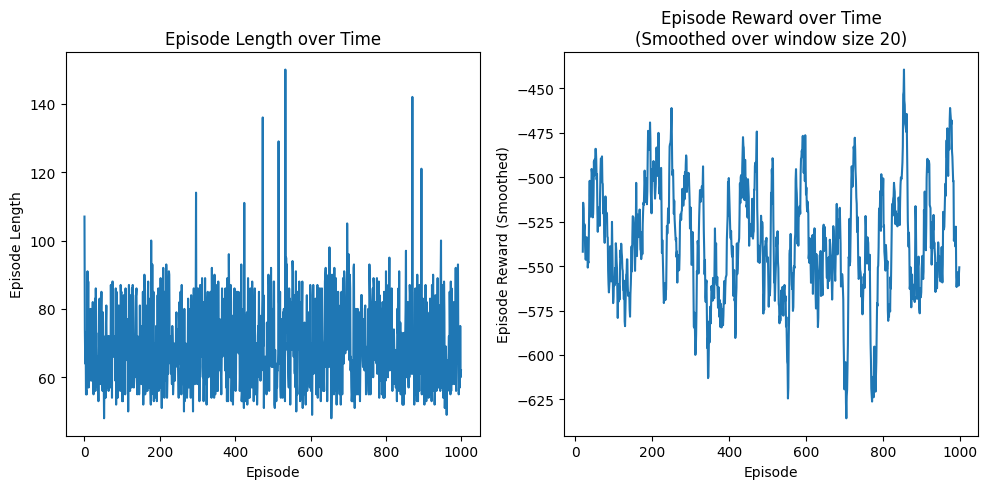

In [39]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time") 

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

Lastly, let us see what the learned policy does in action.

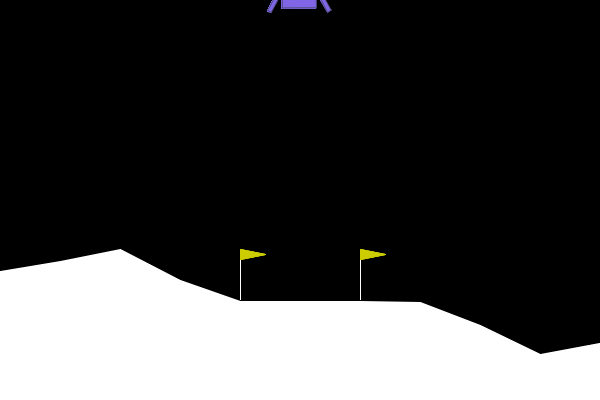

In [27]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array).astype(np.uint8)
        img = Image.fromarray(rgb_array)
        frames.append(img)
    
    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        with torch.no_grad():
            action = policy(torch.as_tensor(obs, dtype=torch.float32)).cpu().numpy()
            
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        if terminated or truncated:
            break

    return imgs

imgs = rendered_rollout(loaded_actor, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")

We did not train very far because it can be very time-consuming.

---
<span style="color:orange">**EXERCISE**</span>: **Over Estimation Bias**

1. One of the common issues with Q-Learning based algorithms is the Over Estimation Bias. Explain in detail what is over estimation bias and the reason behind it. 
2. One of the algorithms that closely resembles DDPG is (Twin Delayed Deep Deterministic policy gradient (TD3))[https://arxiv.org/pdf/1802.09477.pdf], what strategy did they employ to address the over estimation bias?

**Your answers:**
1. ...
2. ...